# **Hotel Rating Classification**

# **Problem Statement**

**T and major objective is what are the attributes that travelers are**
**considering while selecting a hotel. With this manager can understand which**
**elements of their hotel influence more in forming a positive review or improves** 
**hotel brand image. 10**

# **Import Necessary Libraries**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix, balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.base import BaseEstimator, TransformerMixin

from textblob import TextBlob
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, FunctionTransformer 

#from pickle import dumps
from pickle import load

from dill import dumps as dp
from dill import loads as ld 
from cloudpickle import dump
import joblib

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df=pd.read_csv('Hotel Review Dataset.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# **EDA**

## **Text data understanding & checking missing/null values**

In [ ]:
# Checking the size of dataset
df.shape

(20491, 2)

In [ ]:
#Summarizing the overall dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
#Checking the null values in dataset
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
#Checking the duplicate values
df.duplicated().sum()

0

In [ ]:
#Statistical description of data (reviews)
df.describe(include='O')

,Review
count,20491
unique,20491
top,nice hotel expensive parking got good deal sta...
freq,1


In [ ]:
#Statistical description of data (ratings)
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [ ]:
#Unique rating values 
sorted(df['Rating'].unique())

[1, 2, 3, 4, 5]

In [ ]:
#Count of Ratings
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

**NOTE:**

* From above analysis, we can say that there are no null values & duplicate data in our dataset.

## **Data Visualization**

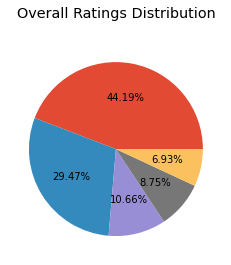

In [ ]:
#Checking the total contribution of all ratings
plt.pie(df['Rating'].value_counts(), autopct='%1.2f%%')
plt.title('Overall Ratings Distribution\n')
plt.show()

**NOTE:**

* From above visual, we can say that almost 75% of reviews are rated (5, 4) by users and remaining 25% reviews are rated (3, 2, 1).

* We have an unequal distribution of data, where we have less no. of negative ratings provided by users.

* Hence, our dataset is highly imbalanced dataset.

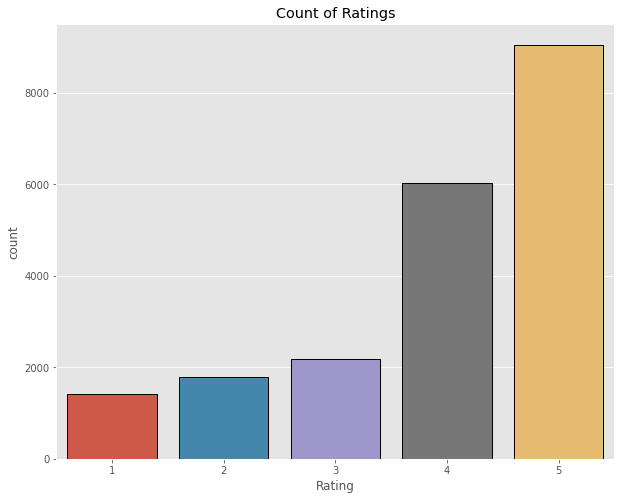

In [ ]:
#Visualizing the unique values of ratings
plt.figure(figsize=(10,8))

ax = sns.countplot(data = df , x = 'Rating', edgecolor='black', linewidth=1)
    
plt.title('Count of Ratings')
plt.show()

**NOTE:**

* From above visual, we can say that count of ratings for 4, 5 are comparatively much higher than the other rating scores.

* Hence, we can say for our data that most of the users are highly satisfied with their experience at hotels.

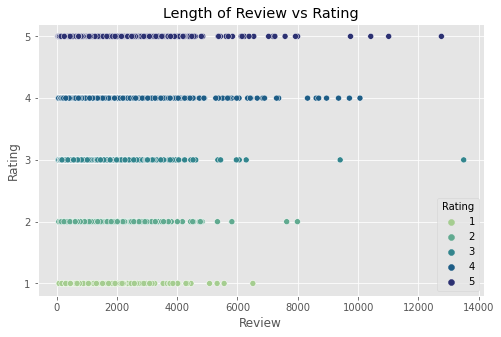

In [ ]:
#Checking the length of words in a review for all the rating
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Review'].apply(len), y=df['Rating'], data=df, palette='crest', hue='Rating')
plt.title('Length of Review vs Rating')
plt.yticks([1,2,3,4,5])
plt.show()

**Note:**

* From above visual, we can say that the length of review has an effect on ratings.

* Lower ratings have lower length of review compared to top ratings.

* Hence, there exists a positive correlation between Length of Reviews & Ratings.

(array([1421., 1793., 2184., 6039., 9054.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

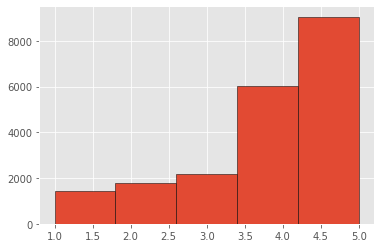

In [ ]:
plt.hist(df["Rating"], bins=5,edgecolor="black")

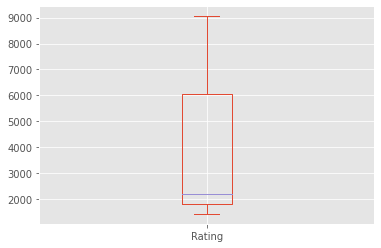

In [ ]:
df.Rating.value_counts().plot(kind="box")

In [ ]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(df, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(df.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

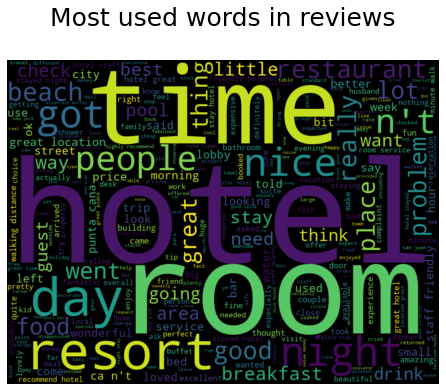

In [ ]:
#Plotting the wordcloud on original data for all ratings
wordCloud_generator(df=df['Review'], title="Most used words in reviews\n")

**NOTE:**

* Hotel, room, time, resort, beach, day, night, & poeple etc. were most commonly used words in overall reviews by users.

In [ ]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(df, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(df.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

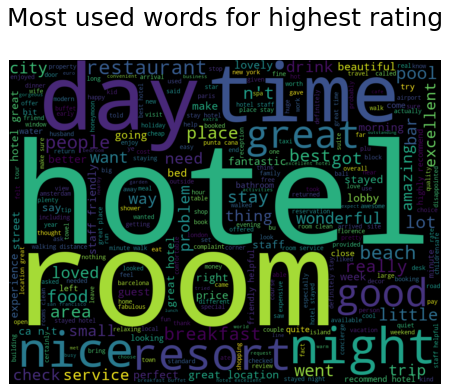

In [ ]:
#Plotting the wordcloud on original data for all highest rating (5)
wordCloud_generator(df=df[df['Rating']==5]['Review'], title="Most used words for highest rating\n")

**Note:**

* Great, nice, wonderful, good, loved, restaurant, hotel, room, day, etc. were some frequently used words by users who rated for score of 5, it seems they had a delightful experience at hotel.

In [ ]:
#Checking the most used words from reviews & plotting it using WordCloud
def wordCloud_generator(df, title=None):
    wordcloud = WordCloud(width = 1000, height = 750, max_words=300,
                          #background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(df.values))
                        
    plt.figure(figsize = (6, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

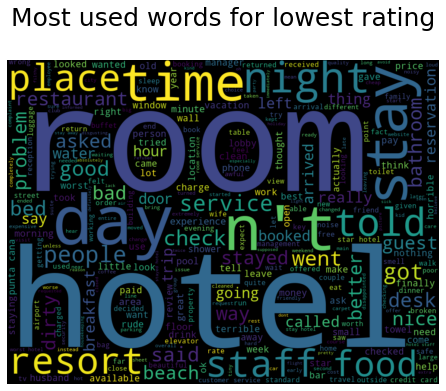

In [ ]:
#Plotting the wordcloud on original data for all lowest rating (1)
wordCloud_generator(df=df[df['Rating']==1]['Review'],title="Most used words for lowest rating\n")

**Note:**

* The users who were not happy or rated low for their experience have used Service, probelm, staff, desk, better, told, dirty, bad, day, hotel, room, food etc. these words frequently in their reviews.

## **Text data Preprocessing & Cleaning**

In [ ]:
#Making a copy of the original dataset
df1 = df.copy()

In [ ]:
#Preview of dataset
df1

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


## **Cleaning the data**

* *Removing punctuations, numeric, symbols, unncessary white spaces, stopwords, etc.*

* *Tokenisation of each words & Applying Lemmatization to the data*

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Object Instantiation
stop_words = nltk.corpus.stopwords.words('english')
stpw = ENGLISH_STOP_WORDS
wnl = WordNetLemmatizer()

In [ ]:
# defined a function for cleaning all reviews in the data set

def clean_text(text):
    
    text = re.sub(r'\w*\d\w*', '', str(text)).strip() #Removing numeric attached with words and return only alpha 
    
    text = re.sub("[\d]+", "", str(text))  # Removing the strings which contains unnecessary digits in data
    
    text = re.sub(r"won\'t", "will not", str(text))      # Replace contraction words
    text = re.sub(r"can\'t", "can not", str(text))      
    text = re.sub(r"ca n\'t", "can not", str(text))      
    text = re.sub(r"wo n\'t", "will not", str(text))     
    text = re.sub(r"\'t've", " not have", str(text))     
    text = re.sub(r"\'d've", " would have", str(text))   
    text = re.sub(r"\'cause", " because", str(text))     
    
    text = re.sub(r"n\'t", " not", str(text))     
    text = re.sub(r"\'re", " are", str(text))     
    text = re.sub(r"\'s", " is", str(text))       
    text = re.sub(r"\'d", " would", str(text))    
    text = re.sub(r"\'t", " not", str(text))      
    text = re.sub(r"\'ve", " have", str(text))    
    text = re.sub(r"\'m", " am", str(text))       

    text = re.sub(r"n\'t", " not", str(text))     
    text = re.sub(r"\'re", " are", str(text))     
    text = re.sub(r"\'s", " is", str(text))       
    text = re.sub(r"\'d", " would", str(text))    
    text = re.sub(r"\'ll", " will", str(text))   
    text = re.sub(r"\'t", " not", str(text))      
    text = re.sub(r"\'ve", " have", str(text))    
    text = re.sub(r"\'m", " am", str(text))       
    
    text = re.sub(r'[^\w\s]', " ", str(text))    # Removing white spaces and returning only alpha characters
    
    text = text.translate(str.maketrans('','',string.punctuation)) # Remove Punctuations
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) # Remove Punctuations
    
    text = ' '.join( [w for w in text.split() if len(w)>1] ) # Removing an unnecessary single character from sentences
    
    text = text.split() #Splitting each word
    
    text = " ".join([word for word in text if word.lower().strip() not in stop_words]) #Removing stopwords, white spaces, making words lower and joining into text
    
    text = text.split() # Splitting each word
    
    text = " ".join([word for word in text if word not in stpw]) # Removing extra stopwords if any
    
    text = nltk.word_tokenize(text)  # Tokenising each words 
       
    text = " ".join([wnl.lemmatize(w, 'v') for w in text])  # Applying Lemmatization

    text = ' '.join(dict.fromkeys(text.split())) #Remove duplicate words from a sentence
    
    return text

In [ ]:
#Object Instantiation
stop_words = nltk.corpus.stopwords.words('english')
stpw = ENGLISH_STOP_WORDS
wnl = WordNetLemmatizer()

In [ ]:
#Testing purpose - reviewing the original reviews before text preprocessing
df1['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

In [ ]:
#Testing purpose - Checking length of original data
len(df1['Review'][2])

1427

In [ ]:
#Testing purpose - reviewing the original reviews after text preprocessing
clean_text(df1['Review'][2])

'nice room experience hotel monaco seattle good level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeep staffnegatives ac unit malfunction stay desk disorganize miss separate wakeup call concierge busy hard touch provide guidance special request tv use ipod sound dock non function decide book night weekend choice rest party fill comparison spend larger square footage great soak tub whirlpool jet shower arrange car service price tip reasonable driver wait arrival checkin easy downside pick person jacuzi bath accessories salt bubble get check voucher bottle champagne gesture fish impression huge open space felt big far away chore change channel break disappoint morning way ask thermostat say degrees warm try cover face bright blue light keep drop maintainence come look tell play settings happy digital box work happen later nap forget yep facilities surprise sell amenities relax water go'

In [ ]:
#Testing purpose - Checking length of preprocessed data
len(clean_text(df1['Review'][2]))

934

In [ ]:
#Applying the clean_text function on entire dataset
df1['Fully_Clean_Text'] = df1['Review'].apply(lambda x: clean_text(x))
df1

,Review,Rating,Fully_Clean_Text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive park get good deal stay a...
1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay go seahawk game awesome downfall vi...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best keep secret time stay charm star beat inc...
20487,great location price view hotel great quick pl...,4,great location price view hotel quick place si...
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff particu...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruin vacation open sept guests wee...


In [ ]:
df1['Length'] = df1['Review'].apply(len)
new_length = df1['Length'].sum()

In [ ]:
df1['Lengths'] = df1['Fully_Clean_Text'].apply(len)
new_lengths = df1['Lengths'].sum()

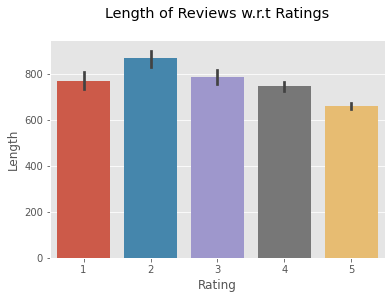

In [ ]:
##Visualizing the length of reviews
sns.barplot(data=df1, x='Rating', y='Length')
plt.title('Length of Reviews w.r.t Ratings\n')
plt.show()

In [ ]:
#Comparing the length of reviews before & after text preprocessing
print('\033[1m'+ "Total Length of Review Comparison" + '\033[0m')
print('=======================================')
print("Before Text Preprocessing : {}".format(new_length))
print('---------------------------------------')
print("After Text Preprocessing  :{}".format(new_lengths))
print('=======================================')

Total Length of Review Comparison
Before Text Preprocessing : 14861007
---------------------------------------
After Text Preprocessing  :10397957


**Note:**

* *We have successfully completed the text preprocessing.*

* *Let's analyse our data further w.r.t Sentiment Analysis.*

# **Sentiment Analysis**

*Sentiment analysis is often performed on textual data to help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.*

##**Using NLTK's VADER - Sentiment Intensity Analyzer**

 *VADER (Valence Aware Dictionary for sEntiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.*

In [ ]:
##Object Instantiation
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#function for Sentiment Analysis
def fetch_sentiment_using_SIA(text):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = sia.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [ ]:
#Applying the VADER function to entire data
df1['SIA_Vader'] = df1.Fully_Clean_Text.apply(lambda x: fetch_sentiment_using_SIA(x))

In [ ]:
#Reviewing the data
df1[['Fully_Clean_Text', 'Rating', 'SIA_Vader']]

,Fully_Clean_Text,Rating,SIA_Vader
0,nice hotel expensive park get good deal stay a...,4,pos
1,ok special charge diamond member hilton decide...,2,pos
2,nice room experience hotel monaco seattle good...,3,pos
3,unique great stay wonderful time hotel monaco ...,5,pos
4,great stay go seahawk game awesome downfall vi...,5,pos
...,...,...,...
20486,best keep secret time stay charm star beat inc...,5,pos
20487,great location price view hotel quick place si...,4,pos
20488,ok look nice modern outside desk staff particu...,2,pos
20489,hotel theft ruin vacation open sept guests wee...,1,pos


In [ ]:
#Drawn a positive sample for testing the sentiment
df1['Fully_Clean_Text'][20487]

'great location price view hotel quick place sight directly street space needle downtown tram science center mall amenities nice indoor pool kid secure underground park garage restaurant room size couple families recommend visit like tostay near'

In [ ]:
#Testing the sample
sia.polarity_scores(df1['Fully_Clean_Text'][20487])

{'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.9231}

In [ ]:
#Drawn a negative sample for testing the sentiment
df1['Fully_Clean_Text'][20489]

'hotel theft ruin vacation open sept guests week happy stumble scout hotels apt stay book gobcn comment post unexpectedly cancel arrival stick place la merce festival barcelona biggest year like try time square new eve vacancies ready towel straight factory wash pilling shower entire sleep proper blanket comforter arrive get chilly night give fleece throw supply sister ciutat lime green colour scheme red black white spare cold drawback double bed single adjoin bother linens separately fish sheet order couple fall lie middle hard firm quality foam pillow best qualities location close las ramblas hear street noise somewhat walkable attractions bari gottic design clean stylish room construction things cement drippings scrap linoleum floor importantly safe securely bolt travel cash come korea unfavorable exchange rate prefer use canadian visa card unsure korean credit work overseas turn husband carry moneybelt life petty problems witness mass humanity wallet separate person blink eye saw s

In [ ]:
#Testing the sample
sia.polarity_scores(df1['Fully_Clean_Text'][20489])

{'neg': 0.161, 'neu': 0.617, 'pos': 0.222, 'compound': 0.9884}

Total Count of Sentiments

pos    95.095408
neg     4.904592
Name: SIA_Vader, dtype: float64 



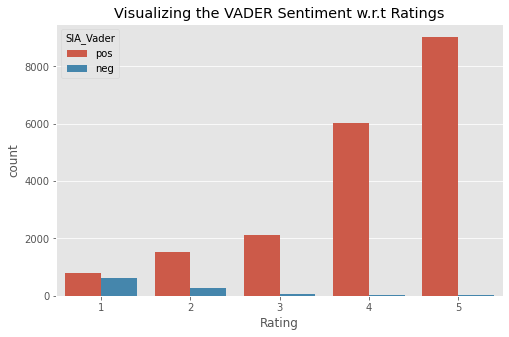

In [ ]:
#Visualizing the Vader Sentiment Analysis
plt.figure(figsize=(8,5))

plt.title("Visualizing the VADER Sentiment w.r.t Ratings")

ax = sns.countplot(data = df1 , x = 'Rating', hue = 'SIA_Vader')

print('Total Count of Sentiments\n')
print(df1['SIA_Vader'].value_counts(['SIA_Vader'])*100, '\n')

**Note:**

* *After testing two random samples, negative sample review is incorrectly tagged as positive.*

* *As we can see, from above sentiment analysis visual almost 95% reviews are tagged as "Positive" using NLTK's VADER approach.*

## **Textblob**

* *TextBlob is a simple library which supports complex analysis and operations on textual data.*

* *It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.*

In [ ]:
#Applying the TextBlob to entire data
df1['TxtB_Polarity'] = df1['Fully_Clean_Text'].apply(lambda x: TextBlob(x).sentiment[0])

In [ ]:
#Reviewing the data
df1[['Fully_Clean_Text', 'Rating', 'TxtB_Polarity']]

,Fully_Clean_Text,Rating,TxtB_Polarity
0,nice hotel expensive park get good deal stay a...,4,0.157805
1,ok special charge diamond member hilton decide...,2,0.184212
2,nice room experience hotel monaco seattle good...,3,0.300569
3,unique great stay wonderful time hotel monaco ...,5,0.468056
4,great stay go seahawk game awesome downfall vi...,5,0.445000
...,...,...,...
20486,best keep secret time stay charm star beat inc...,5,0.200152
20487,great location price view hotel quick place si...,4,0.319048
20488,ok look nice modern outside desk staff particu...,2,0.193365
20489,hotel theft ruin vacation open sept guests wee...,1,0.144561


In [ ]:
#Drawn a positive sample for testing the sentiment
txt = TextBlob(df1['Fully_Clean_Text'][20487])

In [ ]:
#Testing the sample
txt.polarity

0.3190476190476191

In [ ]:
#Testing the sample
txt.sentiment_assessments

Sentiment(polarity=0.3190476190476191, subjectivity=0.5357142857142857, assessments=[(['great'], 0.8, 0.75, None), (['quick'], 0.3333333333333333, 0.5, None), (['directly'], 0.1, 0.4, None), (['center'], -0.1, 0.1, None), (['nice'], 0.6, 1.0, None), (['secure'], 0.4, 0.6, None), (['near'], 0.1, 0.4, None)])

In [ ]:
#Drawn a negative sample for testing the sentiment
txt2 = TextBlob(df1['Fully_Clean_Text'][20489])

In [ ]:
#Testing the sample
txt2.polarity

0.14456093674843673

In [ ]:
#Testing the sample
txt2.sentiment_assessments

Sentiment(polarity=0.14456093674843673, subjectivity=0.5580271965688632, assessments=[(['open'], 0.0, 0.5, None), (['happy'], 0.8, 1.0, None), (['stumble'], -0.05, 0.1, None), (['apt'], 0.6, 1.0, None), (['unexpectedly'], 0.1, 1.0, None), (['new'], 0.13636363636363635, 0.45454545454545453, None), (['ready'], 0.2, 0.5, None), (['straight'], 0.2, 0.4, None), (['entire'], 0.0, 0.625, None), (['proper'], 0.0, 0.1, None), (['chilly'], -0.6, 0.9, None), (['green'], -0.2, 0.3, None), (['red'], 0.0, 0.0, None), (['black'], -0.16666666666666666, 0.43333333333333335, None), (['white'], 0.0, 0.0, None), (['cold'], -0.6, 1.0, None), (['double'], 0.0, 0.0, None), (['single'], -0.07142857142857142, 0.21428571428571427, None), (['middle'], 0.0, 0.0, None), (['hard'], -0.2916666666666667, 0.5416666666666666, None), (['firm'], -0.2, 0.4, None), (['best'], 1.0, 0.3, None), (['clean'], 0.3666666666666667, 0.7000000000000001, None), (['stylish'], 0.5, 1.0, None), (['importantly', 'safe'], 0.5, 0.5, None),

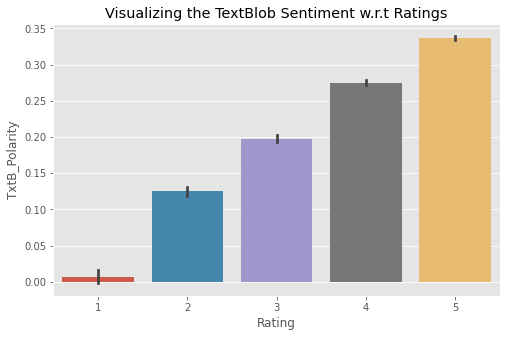

In [ ]:
#Visualizing the TextBlob Sentiment Analysis
plt.figure(figsize=(8,5))

ax = sns.barplot(data= df1, x = 'Rating', y = 'TxtB_Polarity')

plt.title("Visualizing the TextBlob Sentiment w.r.t Ratings")

plt.show()

**Note:**

* Negative reviews polarity scores is not negative but positively low scored. Hence, it is difficult to interpret the positive & negative reviews.

* After testing two random samples, negative sample review is incorrectly tagged as positive using Text Blob.

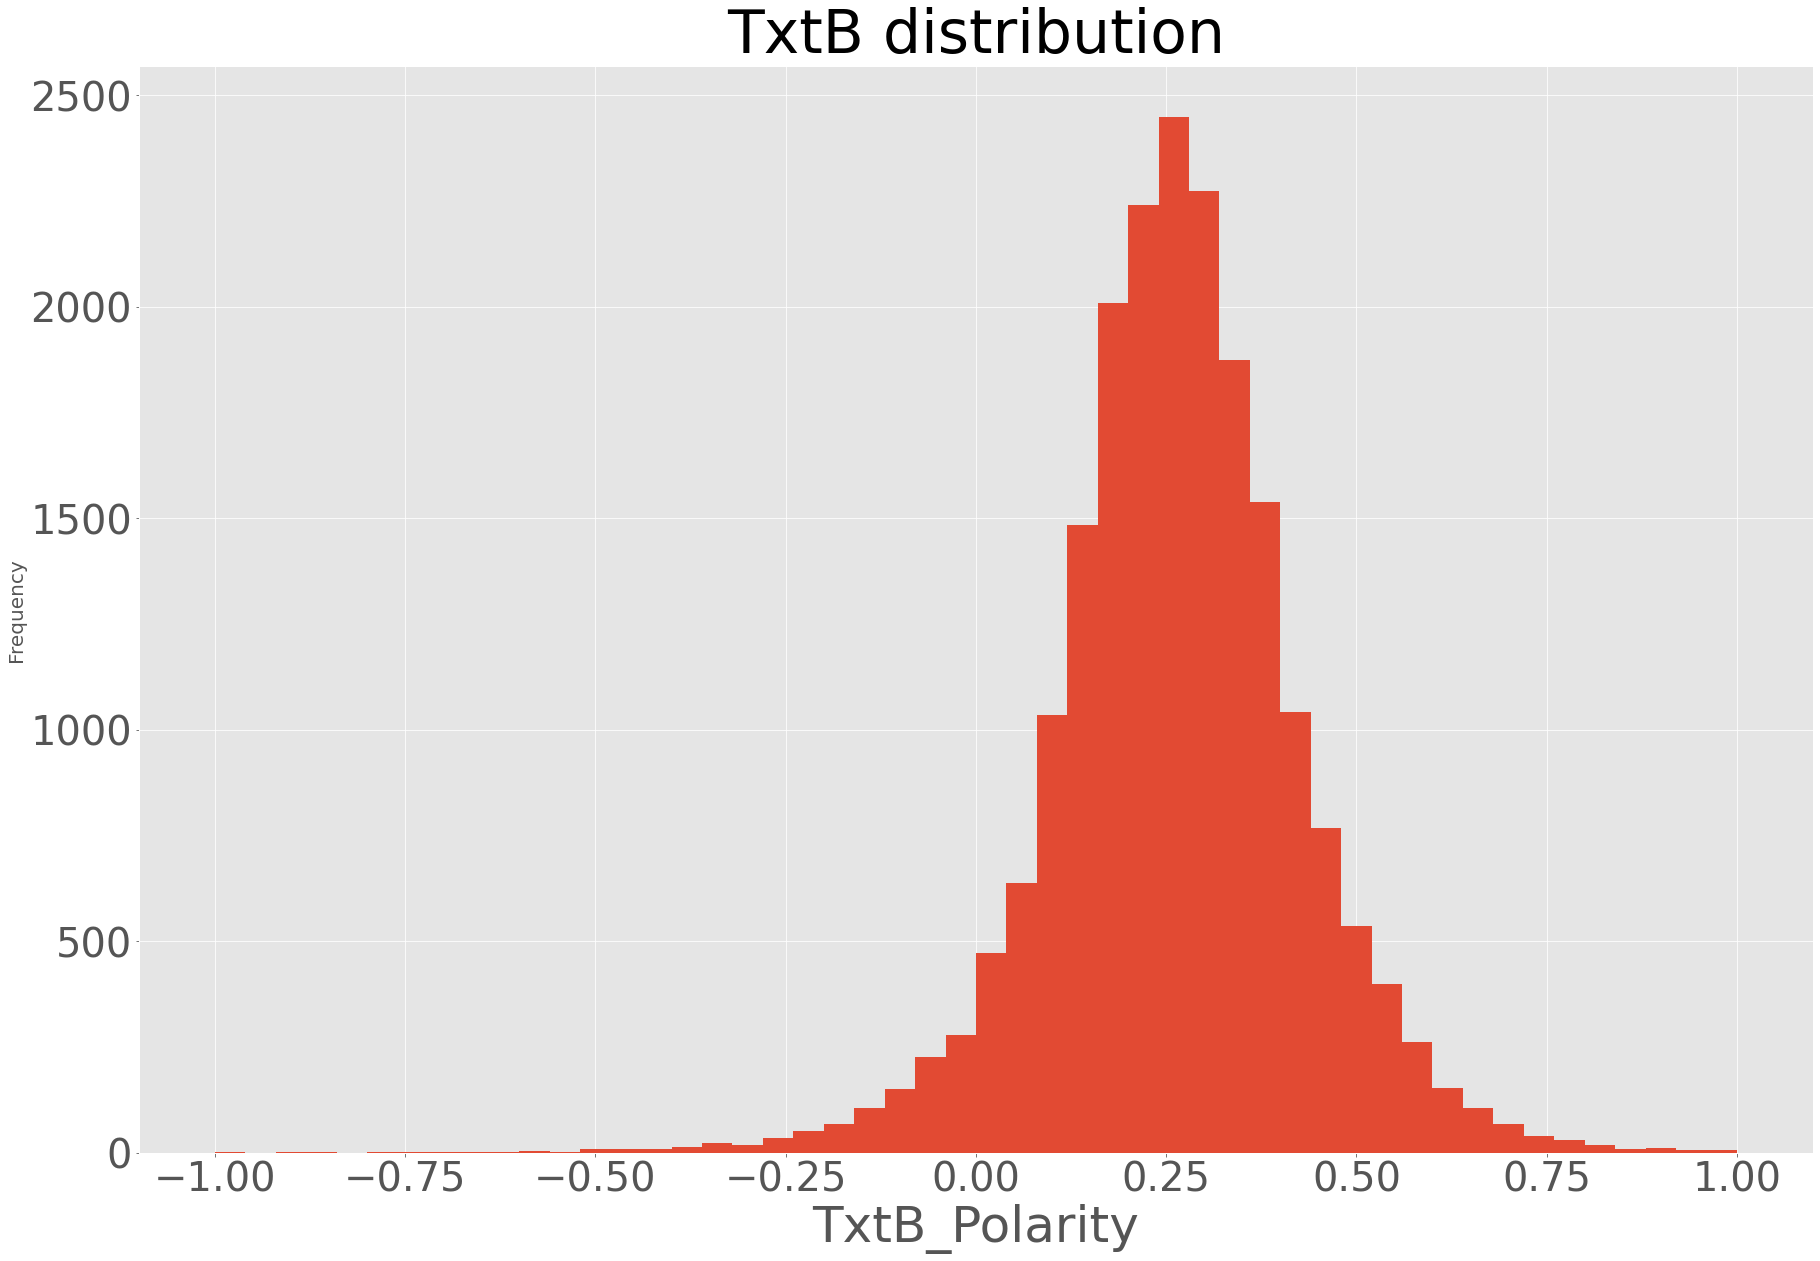

In [ ]:
#for the text polarity we will plot a histogram and observe the distribution.
plt.figure(figsize=(30,20))
plt.xlabel('TxtB_Polarity',fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency',fontsize=20)
plt.yticks(fontsize=40)
plt.hist(df1['TxtB_Polarity'],bins=50)
plt.title('TxtB distribution',fontsize=60)
plt.show()

### *Most of the Distribution lies on right side of 0.00 (i.e,Positive).So,overall we can conclude that the customers are happy with service*

## **Naive Bayes & Logistic Regression based Sentiment Analysis**

## **Label encoding**

In [ ]:
#Converting the ratings into two labels of Positive & Negative
df1['Target'] = df1['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
#New data
df1.head()

,Review,Rating,Fully_Clean_Text,Length,Lengths,SIA_Vader,TxtB_Polarity,Target
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive park get good deal stay a...,593,438,pos,0.157805,1
1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...,1689,1030,pos,0.184212,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1427,934,pos,0.300569,0
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,600,445,pos,0.468056,1
4,"great stay great stay, went seahawk game aweso...",5,great stay go seahawk game awesome downfall vi...,1281,891,pos,0.445000,1


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Review            20491 non-null  object 
 1   Rating            20491 non-null  int64  
 2   Fully_Clean_Text  20491 non-null  object 
 3   Length            20491 non-null  int64  
 4   Lengths           20491 non-null  int64  
 5   SIA_Vader         20491 non-null  object 
 6   TxtB_Polarity     20491 non-null  float64
 7   Target            20491 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 1.3+ MB


In [ ]:
#New data
df2=df1[['Review', 'Rating','Fully_Clean_Text','Length','Lengths','Target']]

In [ ]:
df2.head()

,Review,Rating,Fully_Clean_Text,Length,Lengths,Target
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive park get good deal stay a...,593,438,1
1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...,1689,1030,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1427,934,0
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,600,445,1
4,"great stay great stay, went seahawk game aweso...",5,great stay go seahawk game awesome downfall vi...,1281,891,1


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review            20491 non-null  object
 1   Rating            20491 non-null  int64 
 2   Fully_Clean_Text  20491 non-null  object
 3   Length            20491 non-null  int64 
 4   Lengths           20491 non-null  int64 
 5   Target            20491 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 960.6+ KB


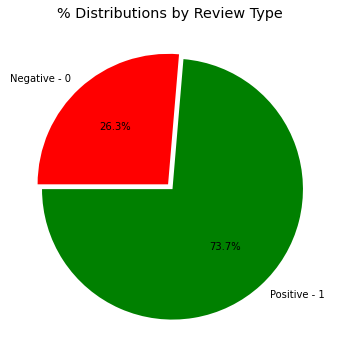

In [ ]:
#Checking the ratings
plt.figure(figsize=(12,6))

g = plt.pie(round(df2.Target.value_counts(normalize=True)*100,2),explode=(0.025,0.025), 
            labels=['Positive - 1', 'Negative - 0'], colors=["g","r"],
            autopct="%1.1f%%", startangle=180)

plt.title("% Distributions by Review Type")

plt.show()

###*From above visual, we can say that most of the reviews are positive and only around 26% are negative reviews.*


## **Feature Extraction**

In [ ]:
#TF-IDF features
vectorizer = TfidfVectorizer()

# **Model building**

###**Naive Bayes**

###**Logistic Regression**

In [ ]:
#Splitting the variables into features & target
X = df2['Fully_Clean_Text']
y = df2['Target']

In [ ]:
#Count of target variable
df2['Target'].value_counts()

1    15093
0     5398
Name: Target, dtype: int64

In [ ]:
#spliting the data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, shuffle=True, stratify=y)

In [ ]:
#Applying TF-IDF vectorizer to train data
X_train = vectorizer.fit_transform(X_train)

In [ ]:
#Applying TF-IDF vectorizer to test data
X_test = vectorizer.transform(X_test)

In [ ]:
LR_mod  = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced')
NB_mod  = MultinomialNB()

In [ ]:
#Model Training with above base models.

%%time
LR_mod.fit(X_train, y_train)
NB_mod.fit(X_train, y_train)

CPU times: user 690 ms, sys: 860 ms, total: 1.55 s
Wall time: 885 ms


MultinomialNB()

In [ ]:
#Model Testing & Evaluation
y_pred_LR  = LR_mod.predict(X_test)
y_pred_NB = NB_mod.predict(X_test)

### ***Analysing the model performance & accuracy***

In [ ]:
#Checking the count of test variable (target)
y_test.value_counts()

1    4528
0    1620
Name: Target, dtype: int64

In [ ]:
#Checking the accuracy for both the models
cc  = [y_pred_LR, y_pred_NB]
mod = ['Logistic Regression', 'Naive Bayes']

print('Accuracy Scores for both models','\n')

for i,j in zip(cc, mod):
    print('===========================')
    print(j, ':', balanced_accuracy_score(y_test, i).round(2))
    print('===========================', '\n')

Accuracy Scores for both models 

Logistic Regression : 0.87

Naive Bayes : 0.54



### ***Confusion Matrix for both models***

Confusion Matrix for both models


Logistic Regression


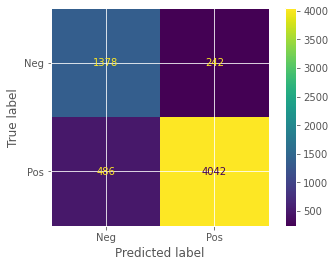



Naive Bayes


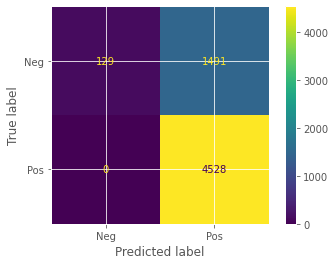

In [ ]:
dd  = [LR_mod, NB_mod]
mod = ['Logistic Regression', 'Naive Bayes']

print('Confusion Matrix for both models')

for i,j in zip(dd, mod):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test, y_test, display_labels= ['Neg', 'Pos'])   
    plt.show()

*  *As per confusion matrix, our goal is minimise the False Positives & Negatives. Hence, Logistc Regression model was able to minimise False Negatives & Positives but still we have to reduce it as much possible.*

In [ ]:
#Classification Report for both models
cc  = [y_pred_LR, y_pred_NB]
mod = ['Logistic Regression', 'Naive Bayes']

print('Classification Report for both models','\n')

for i,j in zip(cc, mod):
    print('========================================================')
    print(j,'\n\n' , classification_report(y_test, i))
    print('========================================================', '\n')

Classification Report for both models 

Logistic Regression 

               precision    recall  f1-score   support

           0       0.74      0.85      0.79      1620
           1       0.94      0.89      0.92      4528

    accuracy                           0.88      6148
   macro avg       0.84      0.87      0.85      6148
weighted avg       0.89      0.88      0.88      6148


Naive Bayes 

               precision    recall  f1-score   support

           0       1.00      0.08      0.15      1620
           1       0.75      1.00      0.86      4528

    accuracy                           0.76      6148
   macro avg       0.88      0.54      0.50      6148
weighted avg       0.82      0.76      0.67      6148




###  *As per classification report, we would try to maximise recall class 0, 1. Naive Bayes model's recall value for class 0 is very poor compared to Logistic Regression model.*

### **As the dataset is highly imbalance, we will try to balance the dataset by applying SMOTE**

**SMOTE: Synthetic Minority Over-sampling Technique**

*It aims to balance class distribution by randomly increasing minority class examples by replicating them*

In [ ]:
#Transforming the data to X & y
X = vectorizer.fit_transform(X)
y = y

In [ ]:
sm = SMOTE(random_state=0)

In [ ]:
#Resampling the dataset with smote
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
#Rechecking the count of target variable after smote
print('X_res after resampling shape : ' , X_res.shape)
print('y_res after resampling shape : ' , y_res.shape, '\n')
print(y_res.value_counts())

X_res after resampling shape :  (30186, 43131)
y_res after resampling shape :  (30186,) 

1    15093
0    15093
Name: Target, dtype: int64


**Now, our dataset is balanced so we can build the model.**

In [ ]:
#Splitting data into training and testing dataset 
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=0, test_size=0.35, stratify=y_res)

In [ ]:
#Checking the size of features
X_train_res.shape, X_test_res.shape

((19620, 43131), (10566, 43131))

In [ ]:
#Model Building with default parameters & smote_resampled data

LR_mod2 = LogisticRegression(random_state=0 , max_iter=1000)

NB_mod2 = MultinomialNB()

In [ ]:
#Model training
%%time
LR_mod2.fit(X_train_res, y_train_res)
NB_mod2.fit(X_train_res, y_train_res)

CPU times: user 1.01 s, sys: 1.49 s, total: 2.5 s
Wall time: 1.36 s


MultinomialNB()

In [ ]:
#Model Testing
%%time
y_pred_LR2  = LR_mod2.predict(X_test_res)
y_pred_NB2  = NB_mod2.predict(X_test_res)

CPU times: user 21.5 ms, sys: 22.1 ms, total: 43.6 ms
Wall time: 29.8 ms


## **Analysing the model performance & accuracy**

In [ ]:
#Checking the accuracy for both models
cc  = [y_pred_LR2, y_pred_NB2]
mod = ['Logistic Regression', 'Naive Bayes']

print('Accuracy Scores for both models','\n')

for i,j in zip(cc, mod):
    print('===========================')
    print(j, ':', balanced_accuracy_score(y_test_res, i).round(2))
    print('===========================', '\n')

Accuracy Scores for both models 

Logistic Regression : 0.91

Naive Bayes : 0.88



Confusion Matrix for both models


Logistic Regression


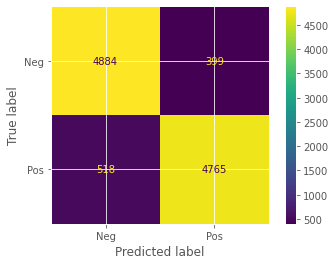



Naive Bayes


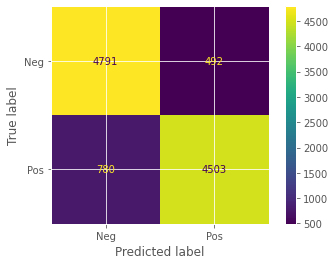

In [ ]:
#Plotting Confusion Matrix for both models
mm = ['Logistic Regression', 'Naive Bayes']
dd = [LR_mod2 ,NB_mod2]

print('Confusion Matrix for both models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_res, y_test_res, display_labels= ['Neg', 'Pos'])   
    plt.show()

In [ ]:
#Classification Report for both models
cc = [y_pred_LR2, y_pred_NB2]
mm = ['Logistic Regression', 'Naive Bayes'] 

print('Classification Report for both models','\n')

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_res, i))
    print('======================================================', '\n')

Classification Report for both models 

Logistic Regression 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      5283
           1       0.92      0.90      0.91      5283

    accuracy                           0.91     10566
   macro avg       0.91      0.91      0.91     10566
weighted avg       0.91      0.91      0.91     10566


Naive Bayes 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      5283
           1       0.90      0.85      0.88      5283

    accuracy                           0.88     10566
   macro avg       0.88      0.88      0.88     10566
weighted avg       0.88      0.88      0.88     10566




### ***Comparing the models imbalance & model smote_balance data with balanced accuracy score***

In [ ]:
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [balanced_accuracy_score(y_test ,y_pred_LR).round(2), balanced_accuracy_score(y_test ,y_pred_NB).round(2)], 
                                                                      'Model2': [balanced_accuracy_score(y_test_res ,y_pred_LR2).round(2), balanced_accuracy_score(y_test_res ,y_pred_NB2).round(2)]
                                                                       })
mod_comp['%Change in Accuracy'] = (mod_comp['Model2'] - mod_comp['Model1'])*100
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Accuracy
Logistic Regression,0.87,0.91,4.0
Naive Bayes,0.54,0.88,34.0


## **From above analysis,**

### *We can say that after applying the sampling method - smote technique to our data, the accuracy has improved by more than 30% for Naive Bayes model.*
### *Also, the recall class 0, 1 has been been improved.*

# **ML Model Stability & Performance**

## **Cross Validation on original data**

In [ ]:
kf = KFold(n_splits=15, shuffle=True, random_state=0)

In [ ]:
cross_val_score(LR_mod, X, y, cv=kf, scoring='accuracy').mean().round(3)*100

88.6

In [ ]:
cross_val_score(LR_mod, X, y, cv=kf, scoring='accuracy').std().round(3)*100

1.0

In [ ]:
cross_val_score(NB_mod, X, y, cv=kf, scoring='accuracy').mean().round(3)*100

76.5

In [ ]:
cross_val_score(NB_mod, X, y, cv=kf, scoring='accuracy').std().round(3)*100

1.3

**The cross validation score is around 89% for Logistic Regression with 1% deviation, 77% for Naive Bayes model with 1.3% deviation on original dataset respectively.**

## **Cross Validation on smote data**

In [ ]:
cross_val_score(LR_mod2, X_res, y_res, cv=kf, scoring='accuracy').mean().round(3)*100

91.8

In [ ]:
cross_val_score(LR_mod2, X_res, y_res, cv=kf, scoring='accuracy').std().round(3)*100

0.7000000000000001

In [ ]:
cross_val_score(NB_mod2, X_res, y_res, cv=kf, scoring='accuracy').mean().round(3)*100

87.7

In [ ]:
cross_val_score(NB_mod2, X_res, y_res, cv=kf, scoring='accuracy').std().round(3)*100

0.6

**The cross validation score is around 92% for Logistic Regression with 0.7 % deviation, 88% for Naive Bayes model with around 0.6 % deviation on smote resampled dataset respectively.**

# **Building Pipeline**

*Making pipeline for the ML classification based models to automate the process of preprocessing, training & predicting the data.*

In [ ]:
def clean_text_frame(X):
    b = clean_text
    return X.applymap(b)

In [ ]:
#Using the mapper to perform specific transformer to the features
m = DataFrameMapper([(['Review'], FunctionTransformer(func=clean_text_frame)),
                      
                    ], df_out=True, input_df=True)

In [ ]:
#Construct the column transfomer
vectorizer1 = TfidfVectorizer()
column_transformer = ColumnTransformer(
    [('Tfidf1', vectorizer1, 'Review')],
    remainder='passthrough')

In [ ]:
#Object Instantiation
mod = LogisticRegression(random_state=0, max_iter=1300)

mod1 = MultinomialNB()

sampling  = SMOTE(random_state=0)

In [ ]:
#Making Pipeline for Logistic Regression
model = Pipeline([ ('Cleaning', m),
                  ('Tfidf', column_transformer), ('SMOTE', sampling), ('MODEL', mod)
                ])

In [ ]:
#Reviewing the pipeline
model

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True,
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x7f7352293820>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)),
                ('MODEL', LogisticRegression(max_iter=1300, random_state=0))])

In [ ]:
#Making Pipeline for Naive Bayes
model1 = Pipeline([ ('Cleaning', m),
                  ('Tfidf', column_transformer), ('SMOTE', sampling), ('MODEL', mod1)
                ])

In [ ]:
#Reviewing the pipeline
model1

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True,
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x7f7352293820>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)), ('MODEL', MultinomialNB())])

# **User Testing**

Now, we will test the pipeline on our dataset

In [ ]:
#Making another copy of original data 
text_data2 = df.copy()

In [ ]:
#Label encoding the target variable
text_data2['Rating'] = text_data2['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
text_data2.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1


In [ ]:
#Picking up 20 random samples from the original data for testing
usx = text_data2.sample(n=20, random_state=12)
usx['Rating'].value_counts()

0    10
1    10
Name: Rating, dtype: int64

In [ ]:
#Index values of samples
usix = usx['Rating'].index

In [ ]:
#Splititing the collected samples for testing
X_t   = usx[['Review']]
y_t   = usx[['Rating']].values

In [ ]:
X_t.shape, y_t.shape

((20, 1), (20, 1))

In [ ]:
#Dropping the collected samples from original dataset so that model is not trained on it
text_data2 = text_data2.drop(index=usix).reset_index()
text_data2 = text_data2.drop('index', axis=1)

In [ ]:
#Reviewing the data after dropping the test samples
text_data2

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,0
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1
...,...,...
20466,"best kept secret 3rd time staying charm, not 5...",1
20467,great location price view hotel great quick pl...,1
20468,"ok just looks nice modern outside, desk staff ...",0
20469,hotel theft ruined vacation hotel opened sept ...,0


In [ ]:
#Splitting the original data for training the model
X_tr = text_data2[['Review']]
y_tr = text_data2[['Rating']].values

In [ ]:
X_tr.head()

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."


In [ ]:
y_tr

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
#Training the model using Logistic Regression
model.fit(X_tr, y_tr)

In [ ]:
#Predicting the test sample
model.predict(X_t)

In [ ]:
#Model performance score
model.score(X_t, y_t)

In [ ]:
#Model Testing & Evaluation - Logistic Regression

print('Actual data:', '   ',y_t.flatten(), '\n')

print('Predicted data: ', model.predict(X_t))

In [ ]:
#model1 = model.fit_resample(X, y)

In [ ]:
#Training the model using Naive Bayes
model1.fit(X_tr, y_tr)

Pipeline(steps=[('Cleaning',
                 DataFrameMapper(df_out=True,
                                 features=[(['Review'],
                                            FunctionTransformer(func=<function clean_text_frame at 0x7f7352293820>))],
                                 input_df=True)),
                ('Tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tfidf1', TfidfVectorizer(),
                                                  'Review')])),
                ('SMOTE', SMOTE(random_state=0)), ('MODEL', MultinomialNB())])

In [ ]:
#Predicting the test sample
model1.predict(X_t)

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1])

In [ ]:
#Model performance score
model1.score(X_t, y_t)

0.95

In [ ]:
#Model Testing & Evaluation - Naive Bayes

print('Actual data:', '   ',y_t.flatten(), '\n')

print('Predicted data: ', model1.predict(X_t))

Actual data:     [0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1] 

Predicted data:  [0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1]


## **Finalising the model**

* *After comparing the performance & accuracy for 2 classification models, both performed well. Since, the accuracy of Logistic Regression has higher precision & recall score we can finalise this model for our dataset.*

* *We can also finalise the pre-trained model, as it was able to correctly judge the statement and also provide a sentiment score thereon.*

* *Hence, we can go ahead and finalise our model 2, since dataset is not complex and overall stability and performance of model is good.*

## **Saving the model**

In [ ]:
#Custom reviews for testing after saving model
tt = {'Review': ['The bed was in such a good condition, I slept on the floor.', 'the food will bring nausea and motion sickness; it was that delicious sick.', 'It was a fucking amazing experience!! Will definitely visit this hotel again.']}
t1 = pd.DataFrame(tt, index=[0,1,2])
t1

,Review
0,"The bed was in such a good condition, I slept ..."
1,the food will bring nausea and motion sickness...
2,It was a fucking amazing experience!! Will def...


In [ ]:
#Saving a joblib model
joblib.dump(model1, 'joblib_model1')

['joblib_model1']

In [ ]:
#Loading a joblib model
mj = joblib.load('joblib_model1')

**Predicting the model based on custom reviews**

In [ ]:
mj.predict(t1)

array([0, 0, 1])

In [ ]:
#Saving the model to file
dump(model1, open('hrsa_intelligence.joblib', 'wb'))

In [ ]:
#Loading the file
ml = load(open('hrsa_intelligence.joblib', 'rb'))

In [ ]:
#Running the file for testing & evaluating custom reviews
print('Predicted Values:', ml.predict(t1))

Predicted Values: [0 0 1]


# **Thank You!!**